In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import jax
import jax.numpy as jnp

from src.spectral_xpci.xscatter import get_delta_beta_mix
from src.spectral_xpci.simulate import get_wavelen, apply_psf, simulate_projection
from chromatix.ops import init_plane_resample
import chromatix.functional as cx

plt.rcParams.update({
    'figure.dpi': 150,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.top': True, 
    'ytick.right': True, 
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'lines.linewidth':1,
    'image.cmap':'gray'
    })

def add_scalebar(ax, sz, Nx, real_dx, real_units):
    width_px = sz * Nx 
    label = f'{real_dx * width_px:.0f} {real_units}'
    scalebar = AnchoredSizeBar(ax.transData, width_px, label, 'lower left', size_vertical=1, frameon=False)
    ax.add_artist(scalebar)

class Material:
    def __init__(self, name, matcomp, density):
        self.name = name
        self.matcomp = matcomp
        self.density = density
    def delta_beta(self, energy):
        delta, beta = get_delta_beta_mix(self.matcomp, np.atleast_1d(energy), self.density)
        return delta.squeeze(), beta.squeeze()

tissue = Material('tissue', 'H(10.2)C(14.3)N(3.4)O(70.8)Na(0.2)P(0.3)S(0.3)Cl(0.2)K(0.3)', 1.06)
bone = Material('bone', 'H(3.4)C(15.5)N(4.2)O(43.5)Na(0.1)Mg(0.2)P(10.3)S(0.3)Ca(22.5)', 1.92)
fat = Material('adipose', 'H(11.4)C(59.8)N(0.7)O(27.8)Na(0.1)S(0.1)Cl(0.1)', 0.95)
alu = Material('aluminum', 'Al(100.0)', 2.699)
pmma = Material('PMMA', 'H(8.06)C(59.98)O(31.96)', 1.19)
water = Material('water', 'H(11.2)O(88.8)', 1.0)
calcium = Material('calcium', 'Ca(100.0)', 1.526)

# Parameters
- All distances are in units [m]
- All energies in [keV]

In [2]:
propdist = 500e-3       
energy = 20
I0 = 1e5  # beam intensity -- effects noise (smaller = noiser)

### Phantom:
phantom_N = 4096
phantom_dx = 10e-6
fov = phantom_N*phantom_dx
z_slices = 10
phantom_dz = fov/z_slices
phantom_shape = jnp.array([z_slices, phantom_N, phantom_N])
print(f'total field of view = {fov*1e2:.3f} cm')
print(f'{1e6*phantom_dx:.2f}-um phantom px', phantom_shape, f'({phantom_N**2 * z_slices * 4/1e6:.6f} MB)')

### Detector:
det_shape = (1024, 1024)               
det_dx = fov / det_shape[0]
det_psf = 'lorentzian'  
det_fwhm = 1e-6
print(f'{1e6*det_dx:.2f}-um det px', det_shape)

### Misc:
key = jax.random.PRNGKey(42)
Nx = phantom_shape[0]
dz = fov/z_slices
N_pad = 100
n_medium = 1  # vacuum  (for free-space propagation)
n_avg = 1  # for multislice, check?
det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')


total field of view = 4.096 cm
10.00-um phantom px [  10 4096 4096] (671.088640 MB)
40.00-um det px (1024, 1024)


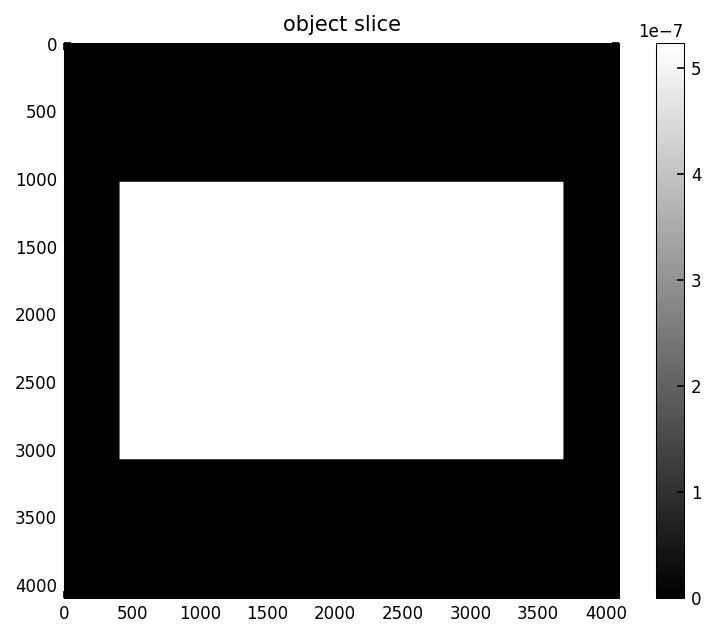

CPU times: user 31.5 s, sys: 14.6 s, total: 46 s
Wall time: 31.2 s


In [3]:
%%time

# Make simple phantom:
coords_xy = np.abs(np.linspace(-phantom_N/2, phantom_N/2, phantom_N))
X, Y = np.meshgrid(coords_xy, coords_xy)
obj = np.zeros(phantom_shape, dtype=jnp.uint8)
for z in range(z_slices):  # lazy, fix
    mask = np.where((X <= 0.4*phantom_N) & (Y <= 0.25*phantom_N))  # some arbitrary rect
    obj[z][mask] = 1

# Assign delta and beta values to each voxel:
matdict = {1: water}
obj_delta = jnp.zeros(obj.shape)
obj_beta = jnp.zeros(obj.shape)
for mat_id in matdict:
    d, b = matdict[mat_id].delta_beta(energy)
    obj_delta = obj_delta.at[obj == mat_id].set(d)
    obj_beta = obj_beta.at[obj == mat_id].set(b)

plt.title('object slice')
plt.imshow(obj_delta[0,:,:])
plt.colorbar()
plt.show()


# Projection approx

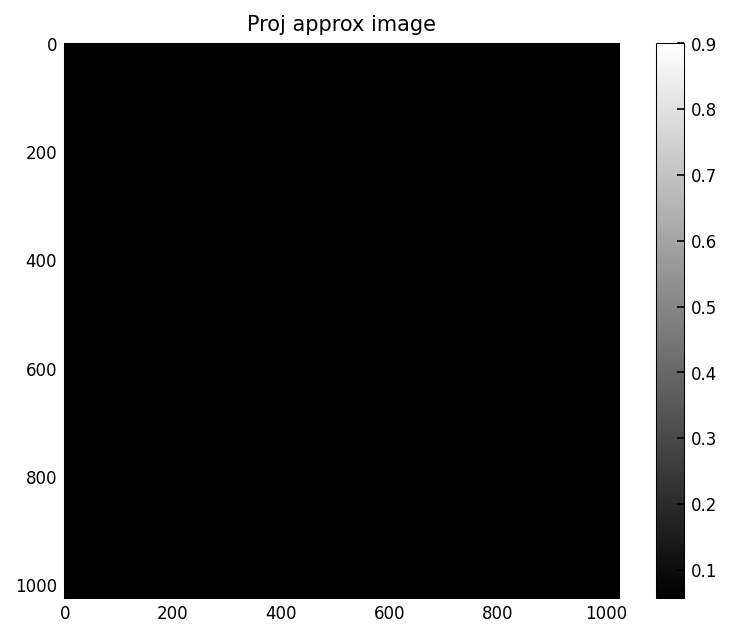

CPU times: user 15min 49s, sys: 15.4 s, total: 16min 5s
Wall time: 2min 10s


In [4]:
%%time

beta_proj = phantom_dz * jnp.sum(obj_beta, axis=0)
delta_proj = phantom_dz * jnp.sum(obj_beta, axis=0)
img_approx = simulate_projection(beta_proj, delta_proj, phantom_dx, phantom_N, det_shape, det_dx, det_fwhm, energy, propdist, I0)  

plt.title('Proj approx image')
plt.imshow(img_approx, vmin=0.9)
plt.colorbar()
plt.show()

# Multislice

I don't have an existing function for this like I do for the proj approx, so I use some of the chromatix pipeline here.

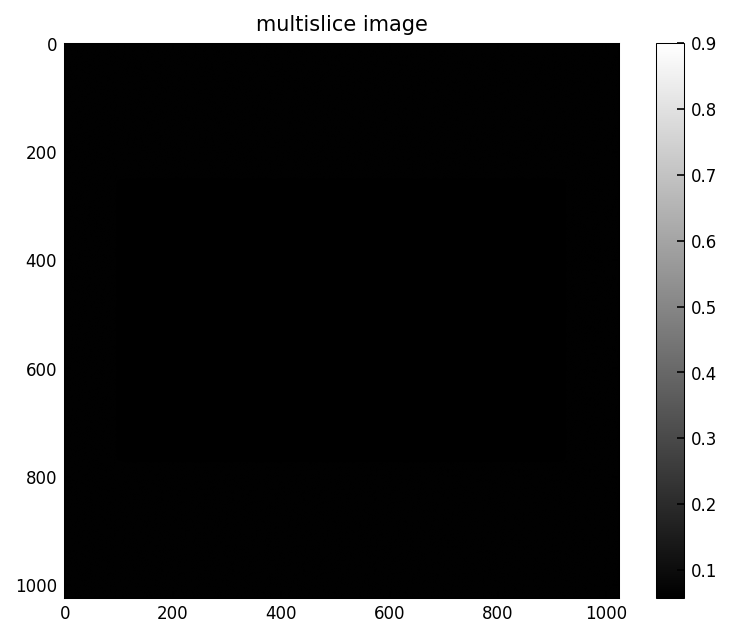

CPU times: user 13min 31s, sys: 16.9 s, total: 13min 48s
Wall time: 2min 7s


In [5]:
%%time

def simulate_multislice(obj_beta, obj_delta, phantom_dx, phantom_dz, phantom_N, z_slices, det_shape, det_dx, det_fwhm, energy, propdist, I0):

    # cailey added this line to troubleshoot / generalize
    # note that cailey also added the function input parameters "phantom_N, z_slices" above
    phantom_shape = jnp.array([z_slices, phantom_N, phantom_N])

    field = cx.plane_wave(
        shape = phantom_shape[1:], 
        dx = phantom_dx,
        spectrum = get_wavelen(energy),
        spectral_density = 1.0,
    )

    field = field / field.intensity.max()**0.5 / ((phantom_N / det_shape[0])**2)  # normalize
    cval = field.intensity.max()

    
    # modulate field thru sample
    exit_field = cx.multislice_thick_sample(field, obj_beta, obj_delta, n_avg, phantom_dz, N_pad)
    
    # propagate thru free space to the detector
    det_field = cx.transfer_propagate(exit_field, propdist, n_medium, N_pad, cval=cval, mode='same')
    
    # resample from phantom resolution -> detector resolution (pixel sizes don't necessarily match)
    det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')
    img_ms = det_resample_func(det_field.intensity.squeeze()[...,None,None], field.dx.ravel()[:1])[...,0,0]
    # img_ms /= img_ms.ravel()[0] 
    # better normalization here! 
    
    # add noise and PSF blur
    img_ms = jax.random.poisson(key, I0*img_ms, img_ms.shape) / I0 # noise
    img_ms = apply_psf(img_ms, fov, det_dx, psf=det_psf, fwhm=det_fwhm, kernel_width=0.1)

    return img_ms

img_ms = simulate_multislice(obj_beta, obj_delta, phantom_dx, phantom_dz, phantom_N, z_slices, det_shape, det_dx, det_fwhm, energy, propdist, I0)

plt.title('multislice image')
plt.imshow(img_ms, vmin=0.9)
plt.colorbar()
plt.show()

# Breast phantom

Inspired by the ACR Digital Mammography Phantom Model 086, specifically looking at small (0.1 cm)^2 ROIs with the tiniest features at 10-micron resolution. This is smaller than typical breast imaging (~50-micron res) but interesting nevertheless.

Compressed breast thickness is probably 5-10 cm. 20 cm is somewhat thick but perhaps more favorable for multislice. We can check out both.

Atomic composition info from NIST: https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html

Note that the phantom itself should be upsampled for accurate simulation (pixel size < 10 um), but then the detector pixel size can be set to 10 um.

In [6]:
nylon = Material('nylon', 'H(9.7980)C(63.6853)N(12.3779)O(14.1388)', 1.15)
glass = Material('glass', 'O(53.9559)Na(2.8191)Al(1.1644)Si(37.7220)K(0.3321)', 2.230)
breast = Material('breast tissue', 'C(33.2)N(3.0)O(52.7)Na(0.1)P(0.1)S(0.2)Cl(0.1)', 1.02)

# example phantom parameters
N = 1024
dx = 1e-6
Nz = 10

In [7]:
def NF(a, E, z):
    return a**2 / (get_wavelen(E)*z)

def print_NF(a, E, z):
    print(f'a={a*1e6:.0f} um, E={E:.0f} keV, z={z*1e2:2.0f} cm : NF={NF(a, E, z):.0f}')

for a in [10e-6, 50e-6]:
    for z in [5e-2, 10e-2, 20e-2]:
        print_NF(a, 15, z)

a=10 um, E=15 keV, z= 5 cm : NF=24
a=10 um, E=15 keV, z=10 cm : NF=12
a=10 um, E=15 keV, z=20 cm : NF=6
a=50 um, E=15 keV, z= 5 cm : NF=605
a=50 um, E=15 keV, z=10 cm : NF=302
a=50 um, E=15 keV, z=20 cm : NF=151


In [8]:
def show_phantom(obj_delta, obj_beta):
    fig, ax = plt.subplots(1, 2, figsize=[8,3])
    fig.suptitle('Line integrals along optical (z) axis')
    for i, obj in enumerate([obj_delta, obj_beta]):
        ax[i].set_title(['delta', 'beta'][i])
        # m = ax[i].imshow(obj[obj.shape[0]//2,:,:])  # central z-slice
        m = ax[i].imshow(np.sum(obj, axis=0))  # central z-slice
        fig.colorbar(m, ax=ax[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    fig.tight_layout()
    plt.show()    

## Nylon fibers

Thin, vertical fibers.

In [9]:
def make_fiber_phantom(N, Nz, dx, fiber_width, energy, fiber_material=nylon, background_material=pmma):

    fov = N*dx
    fiber_height = 0.8*fov
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    X, Y = np.meshgrid(coords, coords)

    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    for z in range(Nz):
        mask = np.where((X <= fiber_width/2) & (Y <= fiber_height/2))  
        obj[z][mask] = 1

    matdict = {0: background_material, 1: fiber_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta




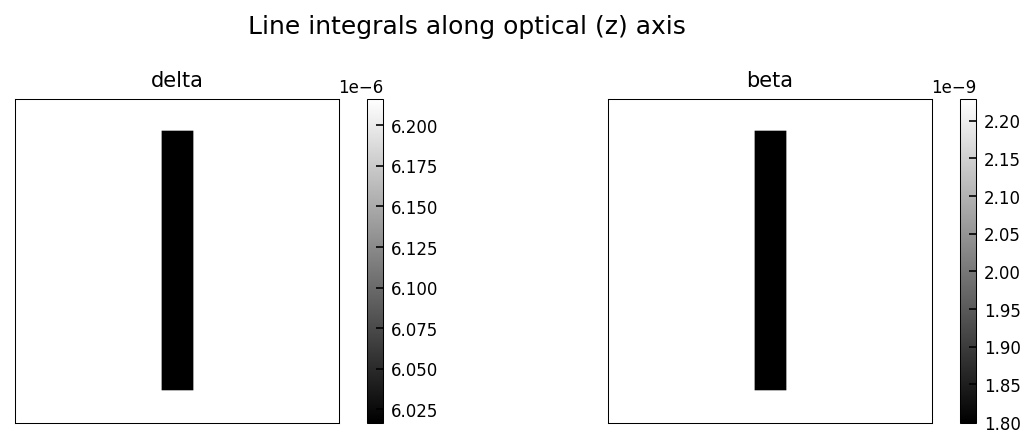

In [10]:
### as a reminder: ###
energy = 20
N = 1024
dx = 1e-6
Nz = 10
######################


################################################################

fiber_width = 100e-6
obj_delta, obj_beta = make_fiber_phantom(N, Nz, dx, fiber_width, energy)

show_phantom(obj_delta, obj_beta)

### Varying Parameters with Fibers

Because glass specks keeps crashing my kernel (as of 01/14/2025)

1. phantom size (feature widths/radii)

fiber width = 1e-05 aka 10 um


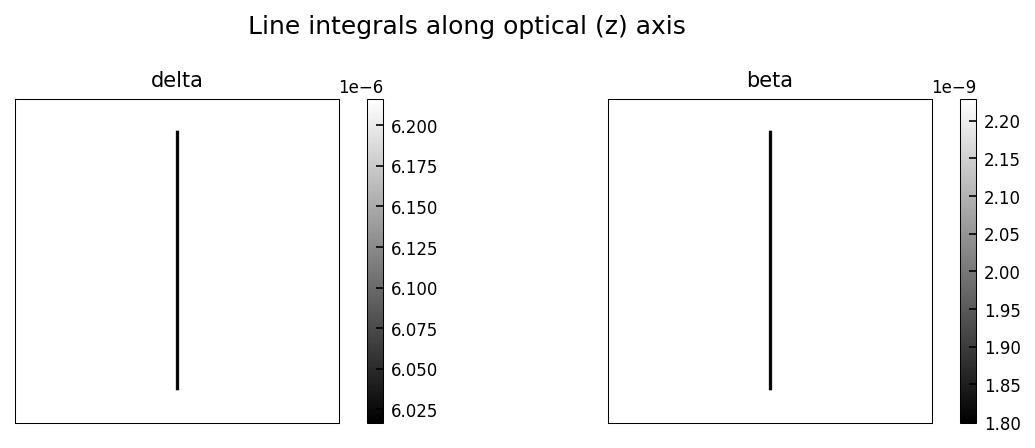

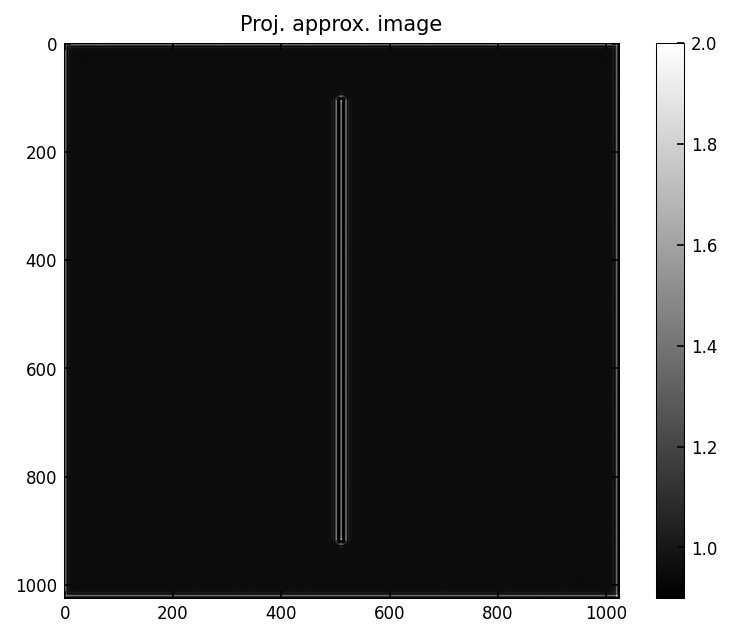

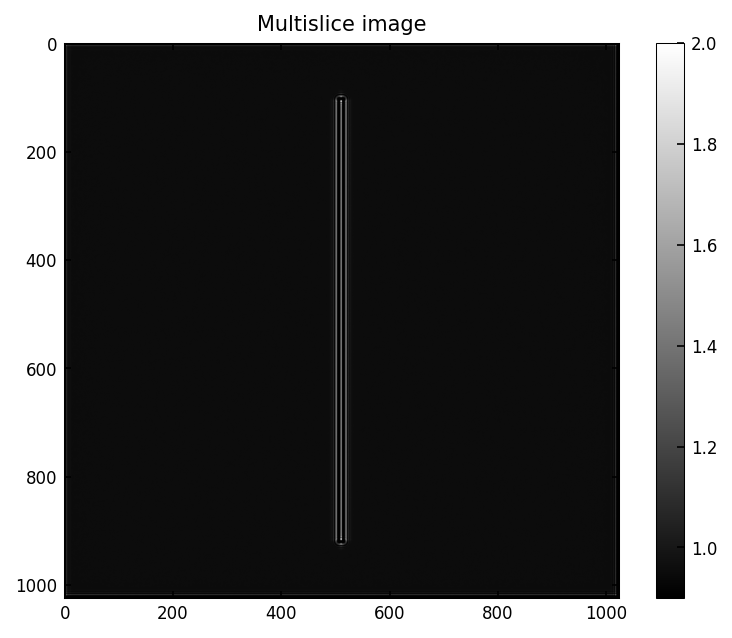

fiber width = 5e-05 aka 50 um


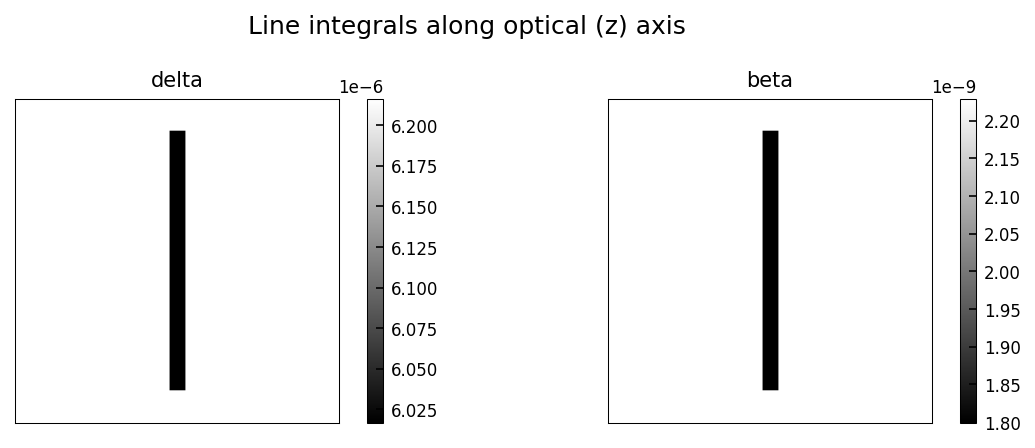

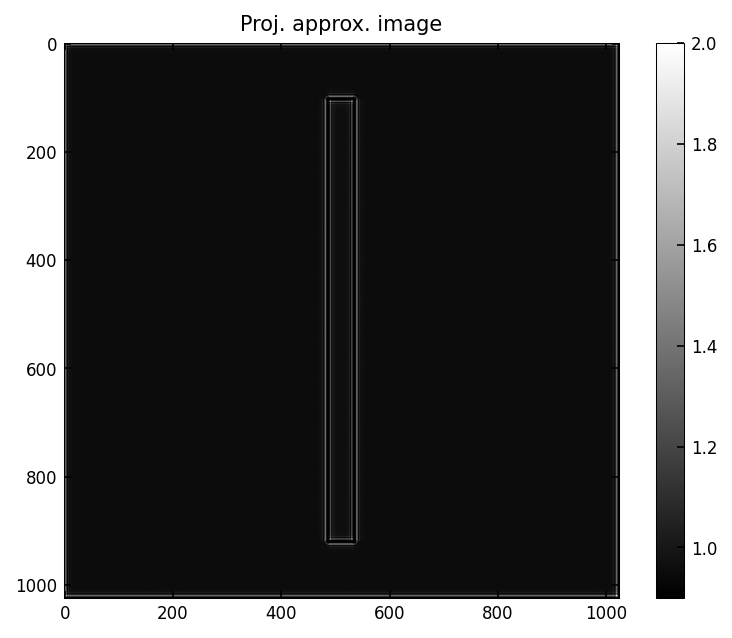

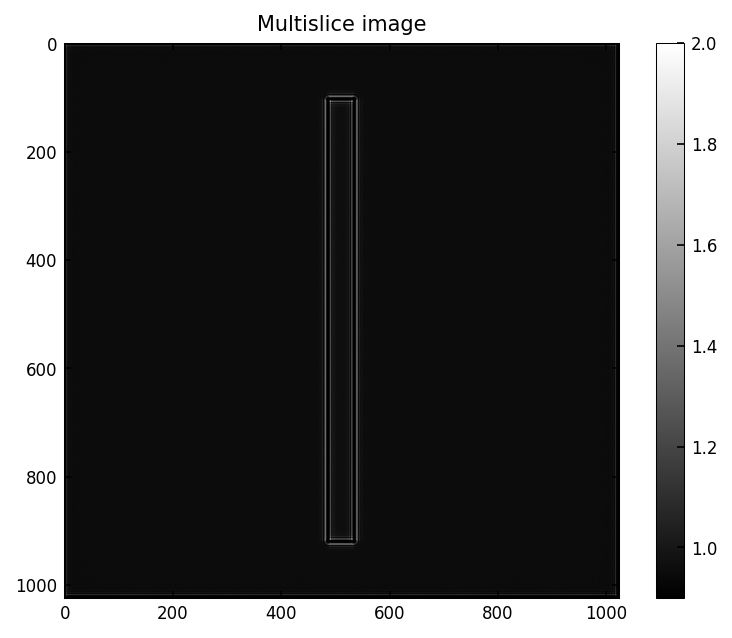

fiber width = 0.0001 aka 100 um


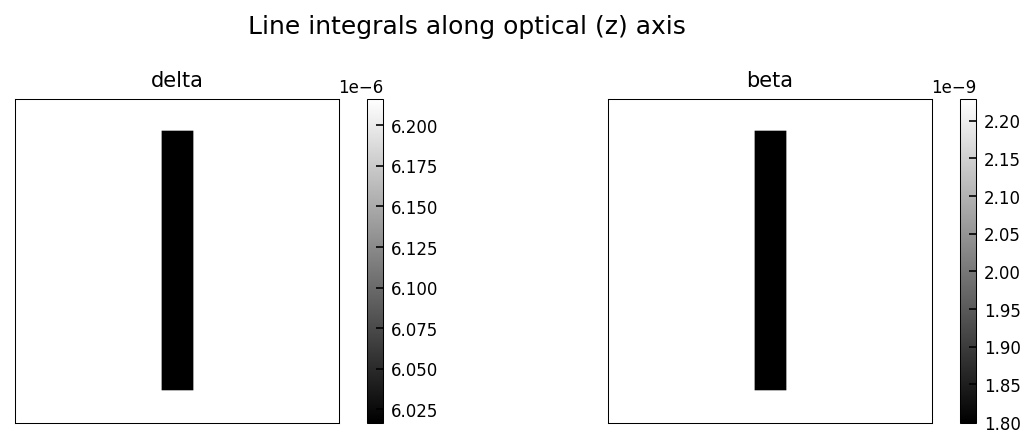

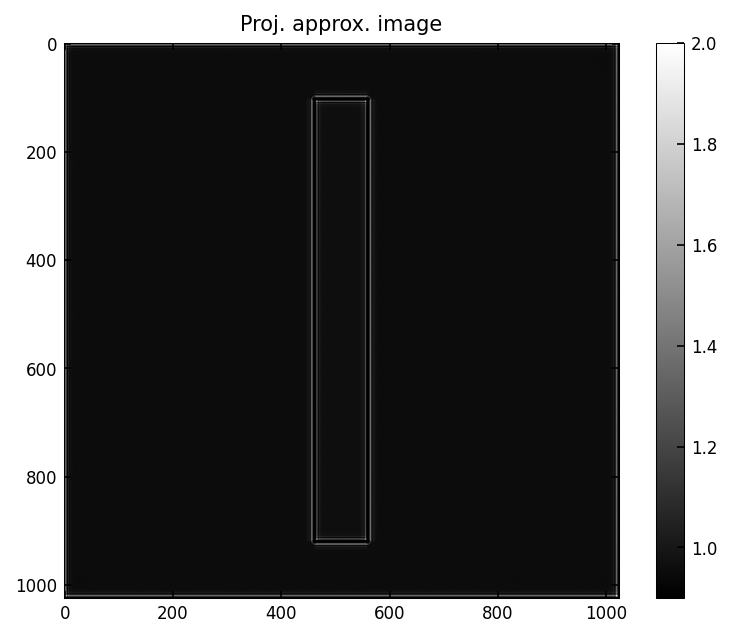

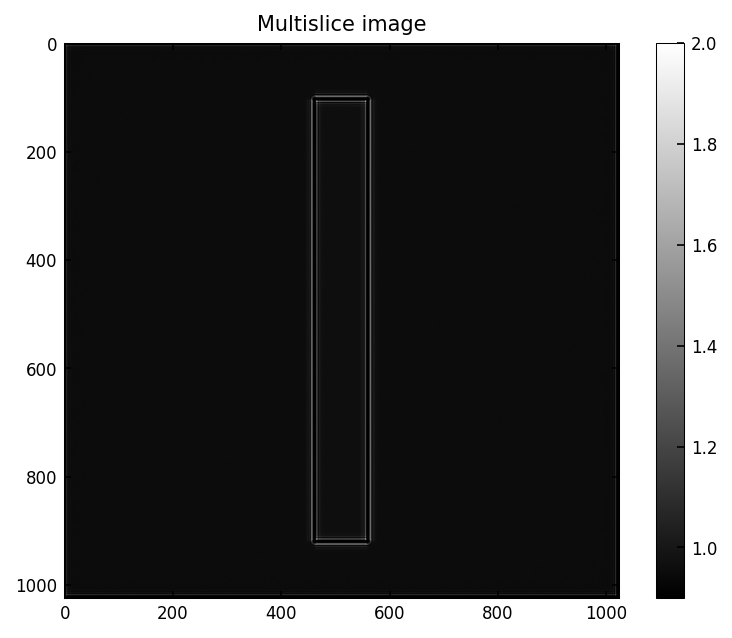

fiber width = 0.0002 aka 200 um


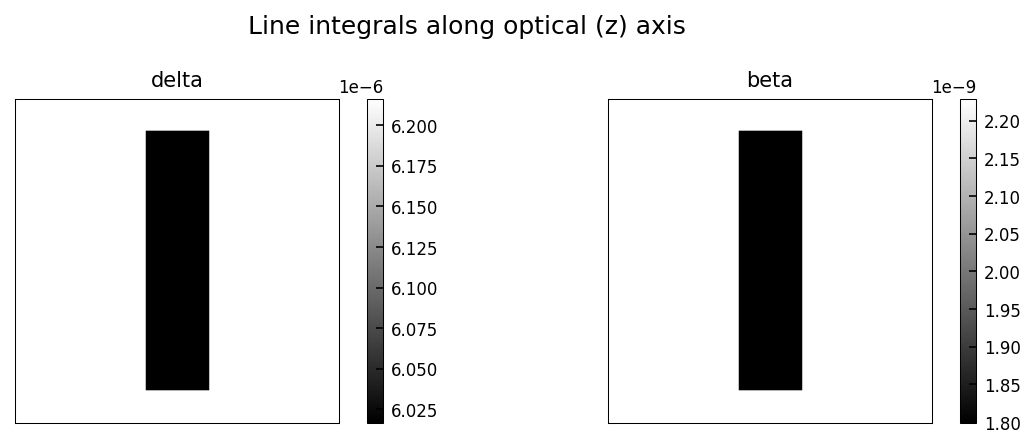

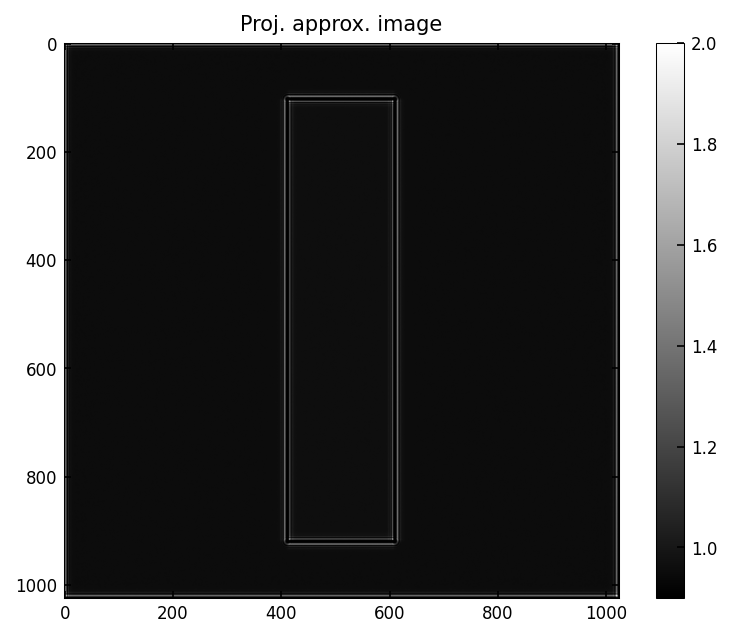

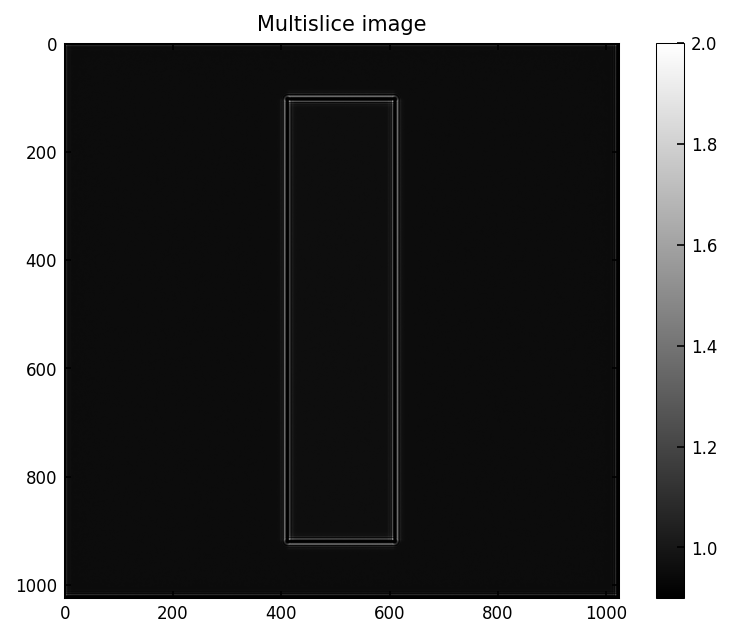

In [13]:
##### parameters #####
### as a reminder: ###
N = 1024
det_shape = (1024, 1024)
det_fwhm = 1e-6
propdist = 500e-3       
energy = 20
I0 = 1e5
dx = 1e-6 
Nz = 10
fov = N*dx
phantom_dz = fov/Nz
det_dx = fov / det_shape[0]
######################

# original fiber_width = 100e-6

# Gray Scale determined by inspection of a previous run:
vmin_a = 0.9
vmax_a = 2.0

for fiber_width in [10e-6, 50e-6, 100e-6, 200e-6]:
    print(f'fiber width = {fiber_width} aka {fiber_width*1e6:.0f} um')

    obj_delta, obj_beta = make_fiber_phantom(N, Nz, dx, fiber_width, energy)

    ### show the phantom directly: ###
    show_phantom(obj_delta, obj_beta)

    ### show the projection approximation: ###
    beta_proj = phantom_dz * jnp.sum(obj_beta, axis=0)
    delta_proj = phantom_dz * jnp.sum(obj_delta, axis=0)
    img_approx = simulate_projection(beta_proj, delta_proj, dx, N, det_shape, det_dx, det_fwhm, energy, propdist, I0)  
    plt.imshow(img_approx, vmin=vmin_a, vmax=vmax_a)
    plt.title('Proj. approx. image')
    plt.colorbar()
    plt.show()

    ### show the multislice approximation: ###
    img_ms = simulate_multislice(obj_beta, obj_delta, dx, phantom_dz, N, Nz, det_shape, det_dx, det_fwhm, energy, propdist, I0)
    plt.title('Multislice image')
    plt.imshow(img_ms, vmin=vmin_a, vmax=vmax_a)
    plt.colorbar()
    plt.show()

2. phantom pixel size in the z-direction

Nz = 1


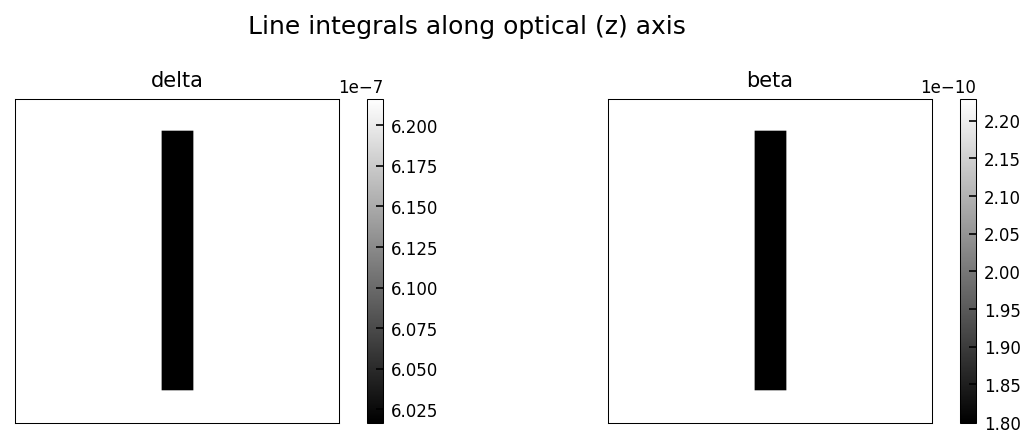

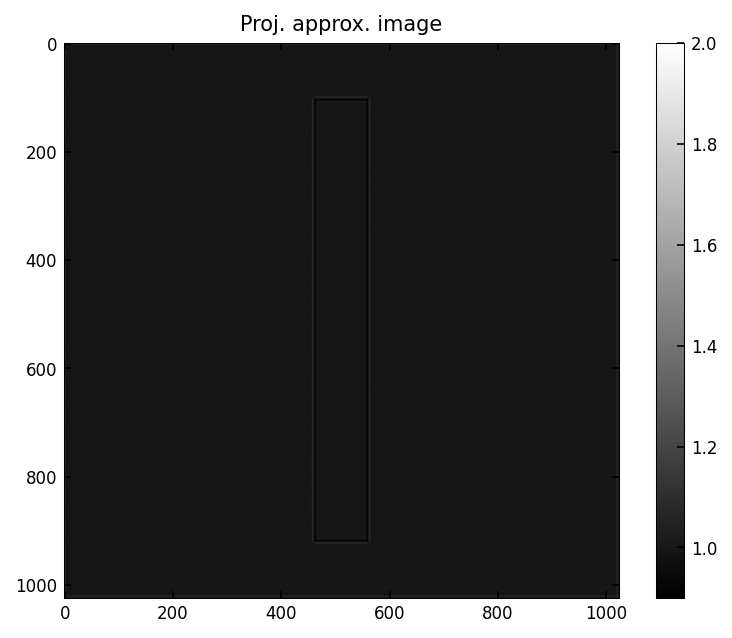

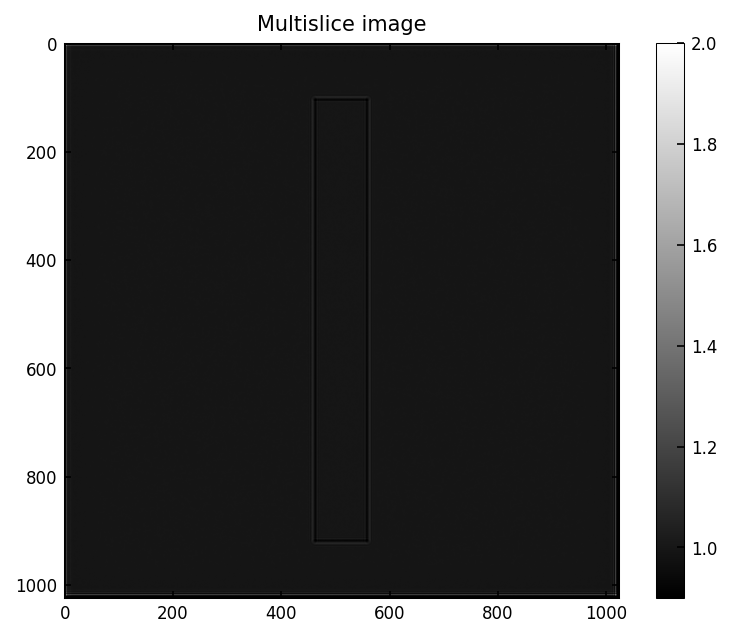

Nz = 5


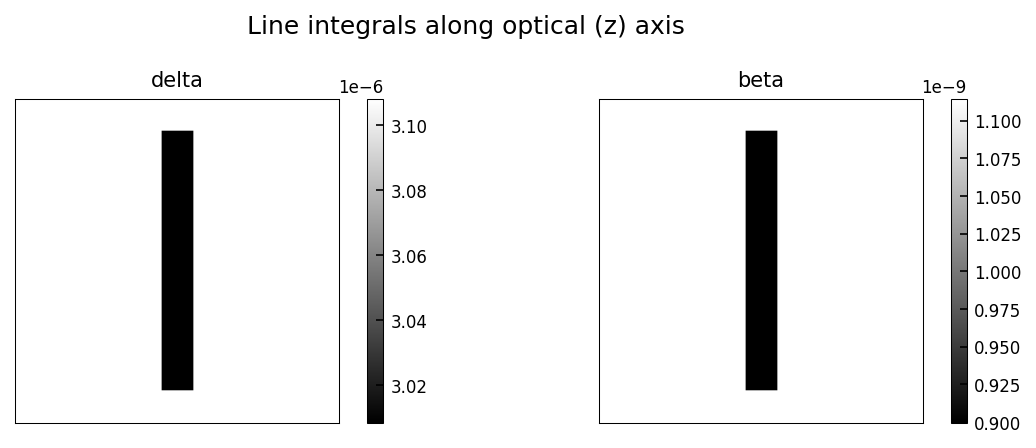

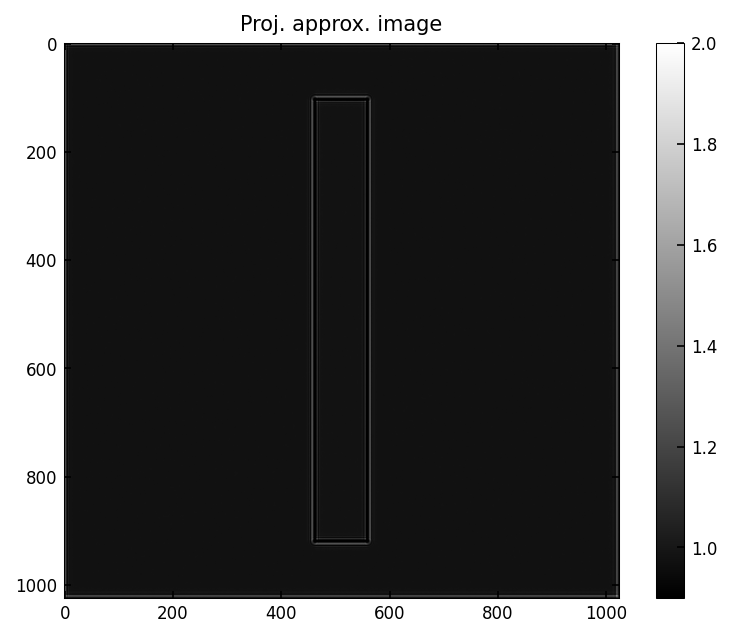

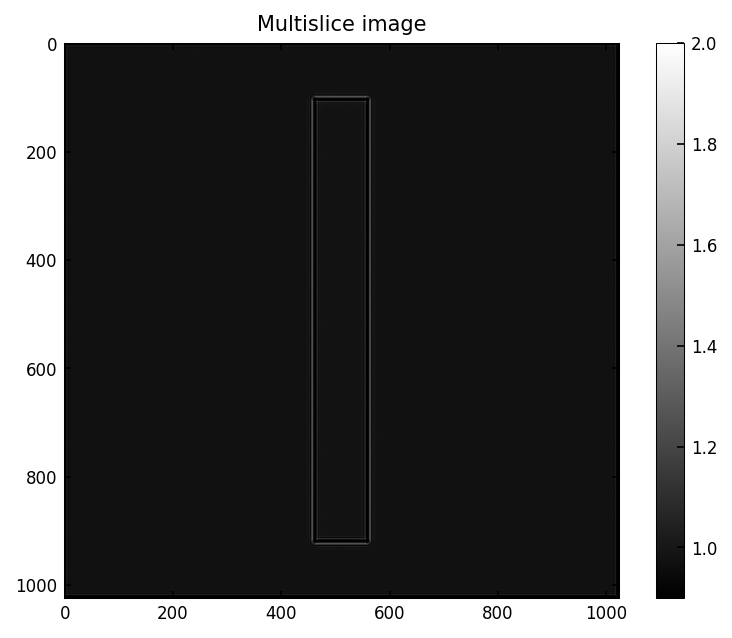

Nz = 10


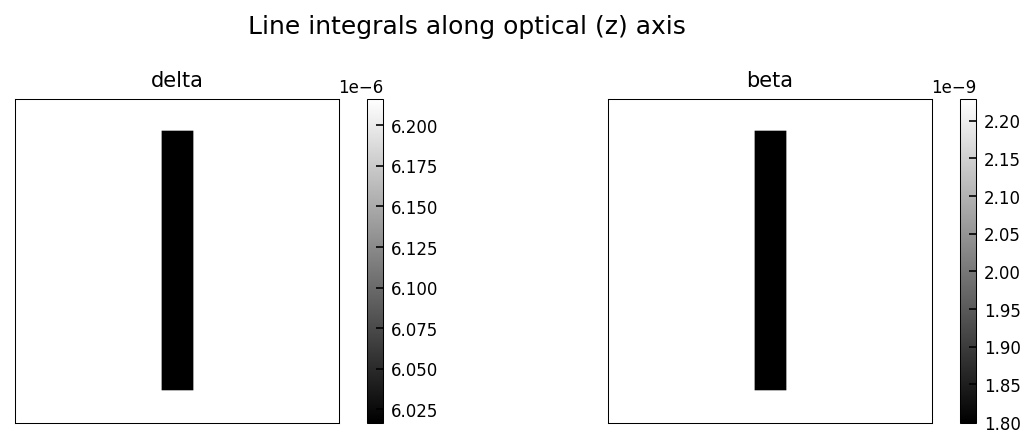

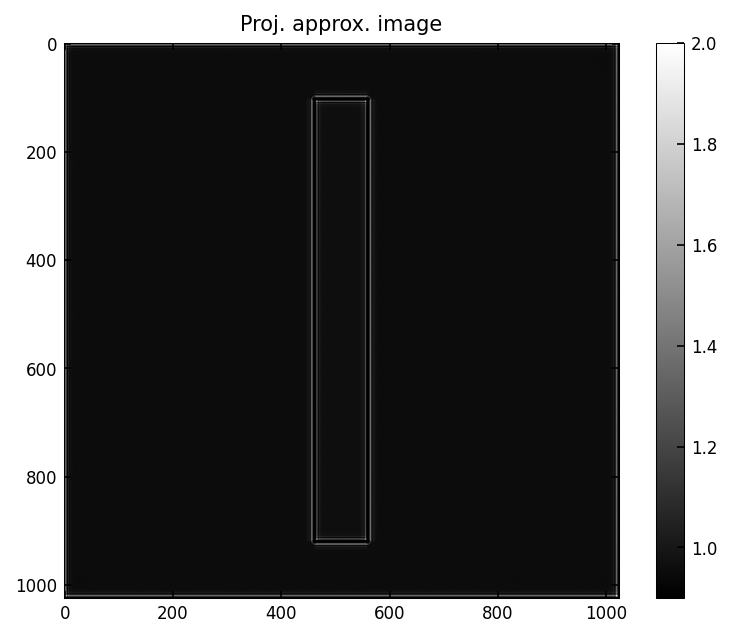

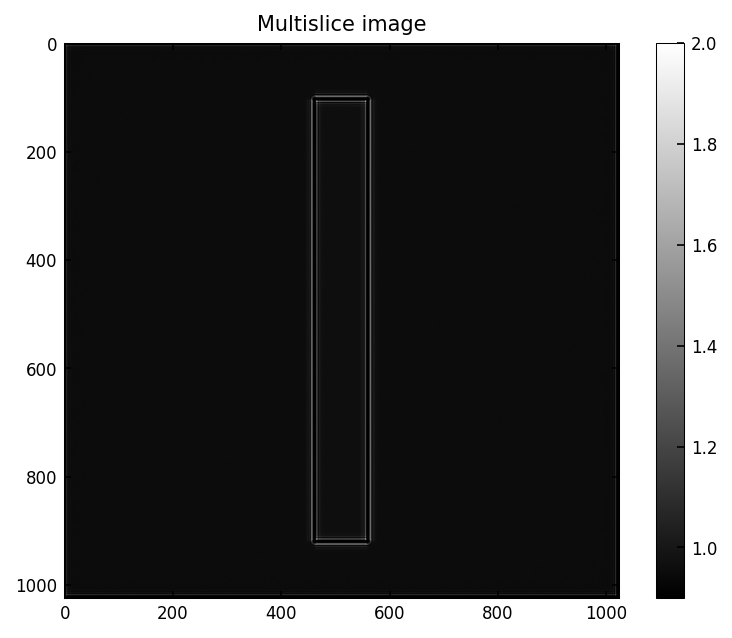

Nz = 20


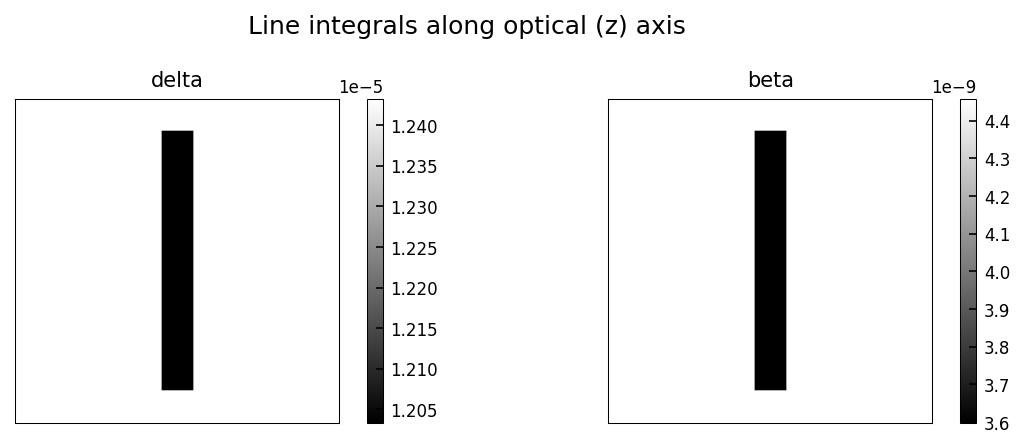

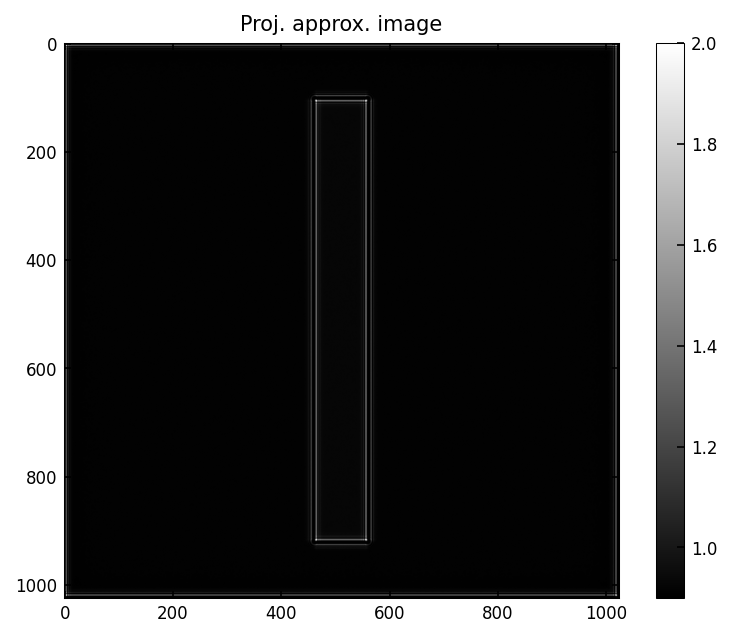

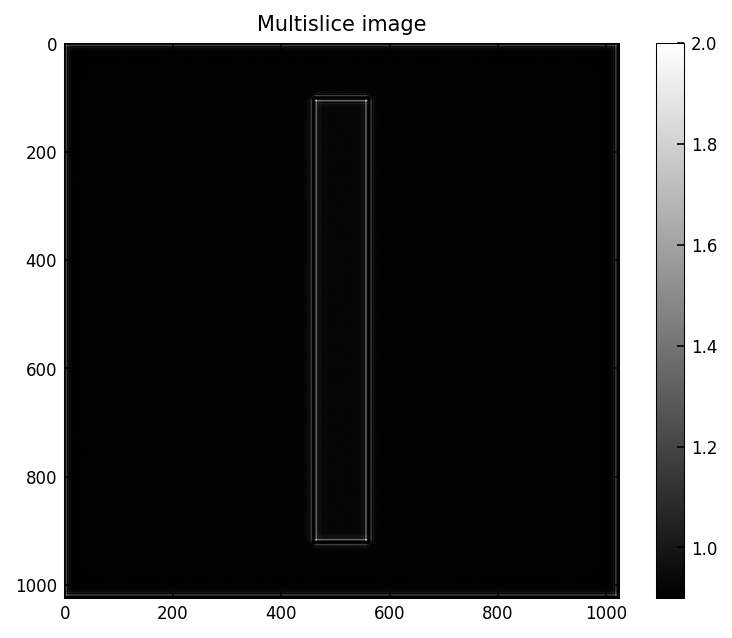

In [14]:
# reset to original width
fiber_width = 100e-6

##### parameters #####
### as a reminder: ###
N = 1024
det_shape = (1024, 1024)
det_fwhm = 1e-6
propdist = 500e-3       
energy = 20
I0 = 1e5
dx = 1e-6 
Nz = 10
fiber_width = 100e-6
fov = N*dx
phantom_dz = fov/Nz
det_dx = fov / det_shape[0]
######################

# Gray Scale determined by inspection of a previous run:
vmin_b = 0.9
vmax_b = 2.0

# Now, to vary Nz. We "should" keep it under 10 um.
for Nz in [1, 5, 10, 20]:
    print(f'Nz = {Nz}')
    obj_delta, obj_beta = make_fiber_phantom(N, Nz, dx, fiber_width, energy)

    ### show the phantom directly: ###
    show_phantom(obj_delta, obj_beta)

    ### show the projection approximation: ###
    beta_proj = phantom_dz * jnp.sum(obj_beta, axis=0)
    delta_proj = phantom_dz * jnp.sum(obj_delta, axis=0)
    img_approx = simulate_projection(beta_proj, delta_proj, dx, N, det_shape, det_dx, det_fwhm, energy, propdist, I0)  
    plt.imshow(img_approx, vmin=vmin_b, vmax=vmax_b)
    plt.title('Proj. approx. image')
    plt.colorbar()
    plt.show()

    ### show the multislice approximation: ###
    img_ms = simulate_multislice(obj_beta, obj_delta, dx, phantom_dz, N, Nz, det_shape, det_dx, det_fwhm, energy, propdist, I0)
    plt.title('Multislice image')
    plt.imshow(img_ms, vmin=vmin_b, vmax=vmax_b)
    plt.colorbar()
    plt.show()

## Glass specks
Cylindrical inserts.

In [13]:
def make_speck_phantom(N, Nz, dx, speck_radius, energy, speck_material=glass, background_material=pmma):

    fov = N*dx
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    X, Y = np.meshgrid(coords, coords)
    speck_shift = 0.15*fov
    assert speck_shift > speck_radius
    
    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    for z in range(Nz):
        for xc in [-speck_shift, speck_shift]:
            for yc in [-speck_shift, speck_shift]:
                mask = np.where(((X-xc)**2 + (Y-yc)**2 < speck_radius**2))  
                obj[z][mask] = 1
                # adjust to decrease in thickness

    matdict = {0: background_material, 1: speck_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta




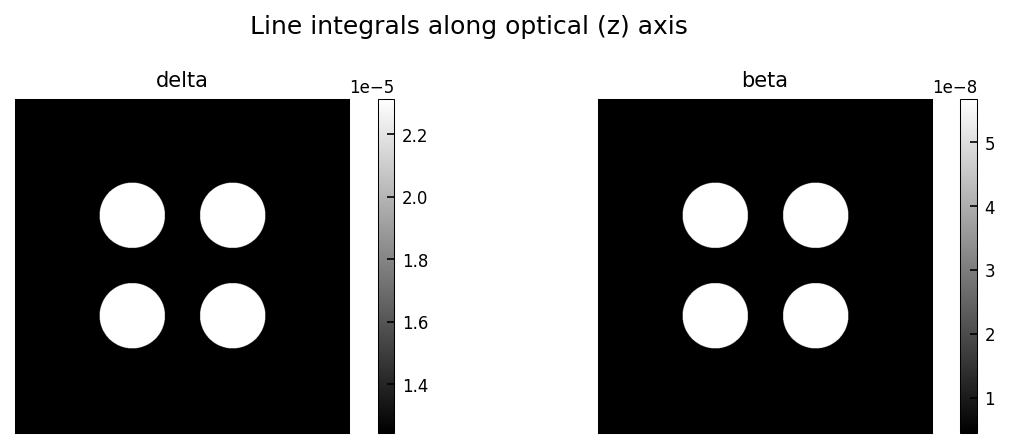

: 

In [ ]:
################################################################

# This is the cell that causes the kernel to crash:

speck_radius = 100e-6
obj_delta, obj_beta = make_speck_phantom(N, Nz, dx, speck_radius, energy)

show_phantom(obj_delta, obj_beta)

## Spherical tissue inserts
Single spheres of breast or adipose tissue.

In [ ]:
%%time

def make_sphere_phantom(N, Nz, dx, radius, energy, sphere_material=breast, background_material=pmma):

    fov = N*dx
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    zcoords = np.abs(np.linspace(-fov/2, fov/2, Nz))
    # field of view should shrink
    # accidentally shrinks sphere, sphere is too large
    Z, X, Y = np.meshgrid(zcoords, coords, coords)

    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    mask = np.where((X**2 + Y**2 + Z**2 < sphere_radius**2)) 
    mask = (mask[1], mask[0], mask[2])  # ? works
    
    obj[mask] = 1

    matdict = {0: background_material, 1: sphere_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta


################################################################

sphere_radius = 200e-6
obj_delta, obj_beta = make_sphere_phantom(N, 100, dx, sphere_radius, energy)  # need larger Nz to resolve sphere curve

show_phantom(obj_delta, obj_beta)


# Simulations with new phantoms

total field of view = 0.128 cm
1.25-um phantom px [ 100 1024 1024] (419.430 MB)
10.00-um det px (128, 128)
projection approx sim done (1.9 s)
multislice sim done (2.4 s)


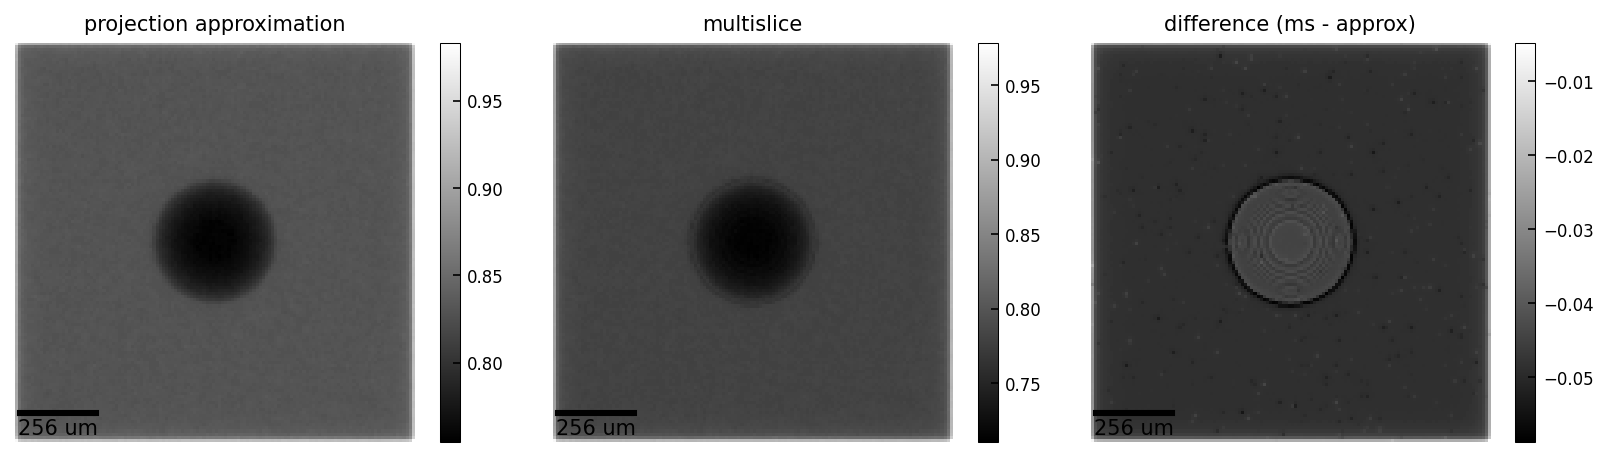

In [12]:
propdist = 10e-2       
energy = 20
I0 = 1e5  # beam intensity -- effects noise (smaller = noiser)

### Phantom:
phantom_N = 1024
phantom_dx = 1.25e-6
z_slices = 100      # number of multislices
z_thickness = 3e-2  # thickness of the phantom along propagation axis
fov = phantom_N*phantom_dx
phantom_dz = z_thickness/z_slices
phantom_shape = jnp.array([z_slices, phantom_N, phantom_N])
print(f'total field of view = {fov*1e2:.3f} cm')
print(f'{1e6*phantom_dx:.2f}-um phantom px', phantom_shape, f'({phantom_N**2 * z_slices * 4/1e6:.3f} MB)')

### Detector:
det_shape = (128, 128)               
det_dx = fov / det_shape[0]
det_psf = 'lorentzian'  
det_fwhm = 10e-6
print(f'{1e6*det_dx:.2f}-um det px', det_shape)

sphere_radius = 200e-6
obj_delta, obj_beta = make_sphere_phantom(phantom_N, z_slices, phantom_dx, sphere_radius, energy) 


################################################## 
### Simulations

t0 = time()
beta_proj = phantom_dz * jnp.sum(obj_beta, axis=0)
delta_proj = phantom_dz * jnp.sum(obj_beta, axis=0)
img_approx = simulate_projection(beta_proj, delta_proj, phantom_dx, phantom_N, det_shape, det_dx, det_fwhm, energy, propdist, I0)  
print(f'projection approx sim done ({time() - t0:.1f} s)')

t0 = time()
img_ms = simulate_multislice(obj_beta, obj_delta, phantom_dx, phantom_dz, phantom_N, z_slices, det_shape, det_dx, det_fwhm, energy, propdist, I0)
print(f'multislice sim done ({time() - t0:.1f} s)')

diff = img_ms - img_approx
ims = [img_approx, img_ms, diff]
ttls = ['projection approximation', 'multislice', 'difference (ms - approx)']
fig, ax = plt.subplots(1, 3, figsize=[11,3])
for i, stuff in enumerate(zip(ims, ttls)):
    im, ttl = stuff
    ax[i].set_title(ttl)
    m = ax[i].imshow(im)
    fig.colorbar(m, ax=ax[i])
    ax[i].axis('off')
    add_scalebar(ax[i], 0.2, det_shape[0], det_dx*1e6, 'um')
fig.tight_layout()
plt.show()

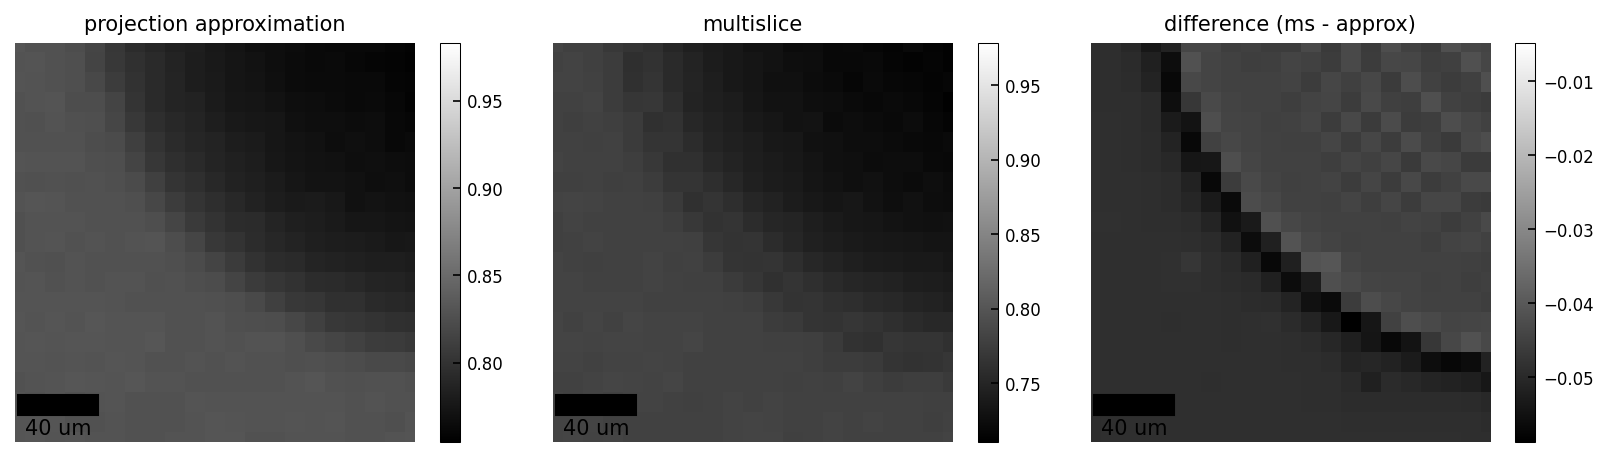

In [13]:
# zoom into an ROI at the phantom edge

xmin, xmax = 40, 60
fig, ax = plt.subplots(1, 3, figsize=[11,3])
for i, stuff in enumerate(zip(ims, ttls)):
    im, ttl = stuff
    ax[i].set_title(ttl)
    m = ax[i].imshow(im)
    fig.colorbar(m, ax=ax[i])
    ax[i].axis('off')
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_ylim(xmin, xmax)  # same bounds for now
    add_scalebar(ax[i], 0.2*(xmax-xmin)/det_shape[0], det_shape[0], det_dx*1e6, 'um')
fig.tight_layout()
plt.show()

# Notes

The slight blurring at the edges of the images is just an artifact from the final detector psf/resampling. We can crop it out for now.

For figures, we should make sure to show the projection approx/multislice images with the same colormapping (same vmin, vmax, etc.)  and maybe we should change the colormap in the "difference" image to make it clear that it is not a simulation.

It will be useful to zoom in on regions of interest (ROIs) at feature edges, since this is where most differences will show up.

Also, the speck phantom and fiber phantom have the same xy slices at all z-levels, whereas the sphere phantom's xy slices vary as a function of z. We want our object to have a much larger length in the z direction (z_thickness) than field-of-view in the xy plane (fov). This results in anistropic voxel dimensions. Out of laziness, I did not code this into the sphere phantom function, so right now, the phantom we're actually using is like an ellipsoid that has been greatly stretched in the z direction to account for the larger thickness. We should fix this at some point (**this is a high priority**).

Things to experiment with, roughly in order of importance:
- (done) phantom type (specks/spheres/fibers) and size (feature widths/radii)
- (done) phantom pixel size, esp. in the z-direction (bigger N_phantom/z_slices improves simulation quality at expense of computational resources)
- detector pixel size / fwhm (these both affect our spatial resolution)
- z_thickness (things bigger than 3cm seem to cause chromatix to fail - is this a bug on our part?)
- energy (15, 20, 25 keV)


## Cailey's To-Do list

todos from 1/15 meeting, before I got sick

- (done) fix phantom normalization issues
- (done) normalize visual color scale on all graphs (for visual comparinsons)
    - I settled on hard-coding an image scale by inspection
- create a quantitative line graph to complement the qualitative images
    - See whiteboard picture
    - phase contrasts should all be the same, one line
    - then add several different multislice lines 
    - color code all lines with a legend on the same graph
- implement post-resampling normalization for multislice (ctrl+F "here!")
- figure out a workaround to my kernel crashing and then continue above goals
